# Stochastic Modelling in fmdtools

This notebook covers the basics of stochastic modelling in fmdtools. Stochastic models are models which run *non-determinsitically*, meaning that simulating the model at the same inputs results in different outputs because of randomness or uncertainty in the model behavior. Thus, to determine the *distribution of outcomes* which may result from a simulation, a stochastic model must be run a number of times. This notebook will cover:
- How to construct a stochastic model by adding *stochastic states* to function blocks and incorporating them in function behavior
- How to simulate single scenarios and distributions of scenarios in `propagate` methods
- How to visualize and analyze the results of stochastic model simulations

In [1]:
from fmdtools.modeldef.approach import SampleApproach, NominalApproach
from fmdtools.modeldef.block import FxnBlock, Block
import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd

import inspect # we will be using inspect to look at 

This notebook uses Pump model in `pump_stochastic.py`, which is an adaptation of the original `ex_pump.py` model with stochastic states added. 

In [2]:
from pump_stochastic import * 

Below is the structure, with the same functions/flows as before.

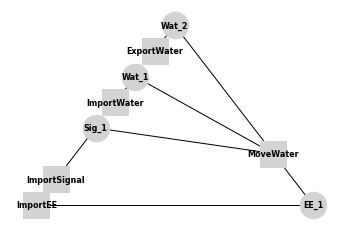

In [3]:
fig, ax = rd.graph.show(Pump())

## Model Setup

This model has been augmented stochastic states and behaviors to enable stochastic simulation. The main method for incorporating stochastic states is `assoc_rand_state`, which is called at function initialization.

In [4]:
help(FxnBlock.assoc_rand_state)

Help on function assoc_rand_state in module fmdtools.modeldef.block:

assoc_rand_state(self, name, default, seed=None, auto_update=[])
    Associate a stochastic state with the Block. Enables the simulation of stochastic behavior over time.
    
    Parameters
    ----------
    name : str
        name for the parameter to use in the model behavior.
    default : int/float/str/etc
        Default value for the parameter for the parameter
    seed : int
        seed for the random state generator to use. Defaults to None.
    auto_update : list, optional
        If given, updates the state with the given numpy method at each time-step.
        List is made up of two arguments:
        - generator_method : str
            Name of the numpy random method to use. 
            see: https://numpy.org/doc/stable/reference/random/generator.html
        - generator_params : tuple
            Parameter inputs for the numpy generator function



The main parameters for `assoc_rand_state` are a name, which will be the name of the variable in the behavior, and default a value, which is both the initial value of the parameter *and* the value of the parameter when the model is run deterministically. That is, fmdtools enables one to run stochastic models *both* using stochastic behaviors (where this number will be updated stochastically) and deterministically (where it will take its default value).

`assoc_rand_states` is the same as `assoc_rand_state`, except one can use it to instantiate multiple states by providing tuples with the form: (name, default).

In [5]:
help(FxnBlock.assoc_rand_states)

Help on function assoc_rand_states in module fmdtools.modeldef.block:

assoc_rand_states(self, *states)
    Associates multiple random states with the model
    
    Parameters
    ----------
    *states : tuple
        can give any number of tuples for each of the states. 
        The tuple is of the form (name, default), where:
            name : str
                name for the parameter to use in the model behavior.
            default : int/float/str/etc
                Default value for the parameter



Below, `assoc_rand_states` is used in the ImportEE function to add two random states:
    - effstate, the quality of the input voltage (i.e. large fluctuations from a step change in power)
    - grid_noise, which is meant to be fluctuations in voltage from the power source (i.e., more ordinary noise)

In [6]:
print(inspect.getsource(ImportEE.__init__))

    def __init__(self,name, flows):
        super().__init__(name,flows, flownames = ['EEout'])
        self.failrate=1e-5
        self.assoc_modes({'no_v':[0.80,[0,1,0], 10000], 'inf_v':[0.20, [0,1,0], 5000]}, key_phases_by='global')
        self.assoc_rand_states(('effstate', 1.0), ('grid_noise',1.0))



This is then reflected in the behavior, which is defined in the `Block.set_rand` method. 

In [7]:
help(Block.set_rand)

Help on function set_rand in module fmdtools.modeldef.block:

set_rand(self, statename, methodname, *args)
    Update the given random state with a given method and arguments (if in run_stochastic mode)
    
    Parameters
    ----------
    statename : str
        name of the random state defined in assoc_rand_state(s)
    methodname : 
        str name of the numpy method to call in the rng
    *args : args
        arguments for the numpy method



In this method, `statename` is the name of the random state, while `methodname` corresponds to the name of a random distribution to update the state from. These distributions are pulled from a numpy random number generator and thus the options for distributions are provided in the numpy documentation: https://numpy.org/doc/stable/reference/random/generator.html#distributions . These distributions include most one might need including normal, beta, uniform, etc. 

`*args` in `set_rand` refers to the corresponding arguments to call the given method with, which should be pulled from the corresponding documentation. Below, we have points where this is called.
- First, to pull `effstate` from a triangular distribution with minimum 0.9, mode 1.0, and max 1.1
 - Parameters are provided here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.triangular.html#numpy.random.Generator.triangular
- Second, to pull `grid_noise` from a normal distribution centered on 1 with a standard deviation that varies over time according to a sine wave.
 - Parameters are provided here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal

In [8]:
print(inspect.getsource(ImportEE.behavior))

    def behavior(self,time):
        if self.has_fault('no_v'):      self.effstate=0.0 #an open circuit means no voltage is exported
        elif self.has_fault('inf_v'):   self.effstate=100.0 #a voltage spike means voltage is much higher
        else:                           
            if time>self.time: self.set_rand('effstate','triangular',0.9,1,1.1)
        if time>self.time:
            self.set_rand('grid_noise','normal',1, 0.1*(2+np.sin(np.pi/2*time)))
        
        self.EEout.voltage= self.grid_noise*self.effstate * 500



The Import Signal function has a similar setup, where `sig_noise` is associated as a random state and then pulled as a random choice from a given set of options. To vary the behavior, here the noise is only pulled every five seconds.

This function also uses the `to_default` method, whic resets a given stochastic state to its default value. Here this is used to zero out any signal noise which would otherwise occur when there is no power.

In [9]:
help(Block.to_default)

Help on function to_default in module fmdtools.modeldef.block:

to_default(self, *statenames)
    Resets (given or all by default) random states to their default values
    
    Parameters
    ----------
    *statenames : str, str, str...
        names of the random state defined in assoc_rand_state(s)



In [10]:
print(inspect.getsource(ImportSig))

class ImportSig(FxnBlock):
    """ Import Signal is the on/off switch """
    def __init__(self,name,flows):
        """ Here the main flow is the signal"""
        super().__init__(name,flows, flownames=['Sigout'])
        self.failrate=1e-6
        self.assoc_modes({'no_sig':[1.0, [1.5, 1.0, 1.0], 10000]}, key_phases_by='global')
        self.assoc_rand_state('sig_noise',1.0)
    def behavior(self, time):
        if self.has_fault('no_sig'): self.Sigout.power=0.0 #an open circuit means no voltage is exported
        else:
            if time<5:      self.Sigout.power=0.0;self.to_default('sig_noise')
            elif time<50: 
                if not time%5:  self.set_rand('sig_noise', 'choice', [1.0, 0.9, 1.1])
                self.Sigout.power=1.0*self.sig_noise
            else:           self.Sigout.power=0.0; self.to_default()



Finally, below the same is done for the `eff` state in `MoveWat`. This function takes advantage of the auto_update option in `assoc_rand_state`, which makes it so that the state automatically updates at each time-step.

This auto-update option uses similar syntax to `set_rand`, where the first argument is the name of the numpy method and the second argument is its parameters. 

In [11]:
print(inspect.getsource(MoveWat.__init__))

    def __init__(self,name, flows, delay):
        flownames=['EEin', 'Sigin', 'Watin', 'Watout']
        states={'total_flow':0.0} #effectiveness state
        self.delay=delay #delay parameter
        super().__init__(name,flows,flownames=flownames,states=states, timers={'timer'})
        self.failrate=1e-5
        self.assoc_modes({'mech_break':[0.6, [0.1, 1.2, 0.1], 5000], 'short':[1.0, [1.5, 1.0, 1.0], 10000]}, key_phases_by='global')
        self.assoc_rand_state("eff",1.0,auto_update=['normal', (1.0, 0.2)])



The advantage of this is that simple stochastic behaviors do not need to be defined in the behavior method, however, it is less flexible than the previous approach, since one is limited to always drawing from the same distribution at each time-step. The resulting behavior method (below) thus has no `set_rand` call, since the state `eff` is automaticall updated outside the behavior definition.

In [12]:
print(inspect.getsource(MoveWat.behavior))

    def behavior(self, time):
        """ here we can define how the function will behave with different faults """
        if self.has_fault('mech_break'):
            self.Watout.pressure = 0.0
            self.Watout.flowrate = 0.0
        else:
            self.Watout.pressure = 10/500 * self.Sigin.power*self.eff*min(1000, self.EEin.voltage)*self.Watin.level/self.Watout.area
            self.Watout.flowrate = 0.3/500 * self.Sigin.power*self.eff*min(1000, self.EEin.voltage)*self.Watin.level*self.Watout.area

        self.Watin.pressure=self.Watout.pressure
        self.Watin.flowrate=self.Watout.flowrate
        if time>self.time: self.total_flow+=self.Watout.flowrate



Finally, it can be helpful for stochastic simulation to include a default seed in the model's modelparams, as shown.

In [13]:
print(inspect.getsource(Pump.__init__))

    def __init__(self, params={'cost':{'repair', 'water'}, 'delay':10, 'units':'hrs'}, \
                 modelparams = {'phases':{'start':[0,4], 'on':[5, 49], 'end':[50,55]}, 'times':[0,20, 55], 'tstep':1,'seed':1}, \
                     valparams={'flows':{'Wat_2':'flowrate', 'EE_1':'current'}}):
        super().__init__(params=params, modelparams=modelparams, valparams=valparams)
        self.add_flow('EE_1', {'current':1.0, 'voltage':1.0})
        self.add_flow('Sig_1',  {'power':1.0})
        # custom flows which we defined earlier can be added also:
        self.add_flow('Wat_1', Water())
        self.add_flow('Wat_2', Water())

        self.add_fxn('ImportEE',['EE_1'],fclass=ImportEE)
        self.add_fxn('ImportWater',['Wat_1'],fclass=ImportWater)
        self.add_fxn('ImportSignal',['Sig_1'],fclass=ImportSig)
        self.add_fxn('MoveWater', ['EE_1', 'Sig_1', 'Wat_1', 'Wat_2'],fclass=MoveWat, fparams = params['delay'])
        self.add_fxn('ExportWater', ['Wat_2'], fclass=Ex

This `seed` parameter ensures that each simulation in the same random thread will produce the same results, and that results can be replicated from stochastic simulation by running the model with the same seed.

## Simulation and Analysis

With this model set up, we can now simulate it using the methods in `propagate`.

### Single-Scenario Simulation

First, let's simulate it in the nominal scenario:

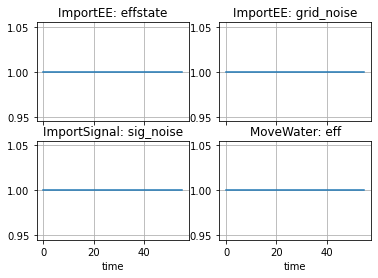

In [14]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl)
fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals = {'ImportEE':["effstate","grid_noise"], 'ImportSignal':'sig_noise', 'MoveWater':'eff' })

As shown, even with all of these random states, it doesn't appear that the behavior actually changes stochastically over time. This is because, by default, `propagate` methods run *deterministically*, meaning the stochastic states take their default values. To run stochastically, we use the option `run_stochastic=True`.

In [15]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl, run_stochastic=True)

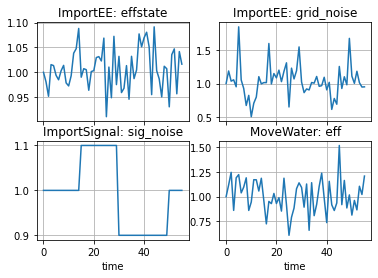

In [16]:
fig = rd.plot.mdlhists(mdlhist, fxnflowvals = {'ImportEE':["effstate","grid_noise"], 'ImportSignal':'sig_noise', 'MoveWater':'eff' })

As shown, this is more what we would expect from a random . Note that this simulation comes from the default model seed, and will this will always be the same. To get a different seed, we can pass new modelparams as an argument to `propagate.nominal`

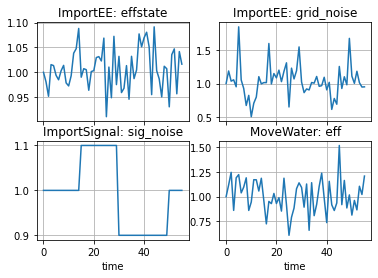

In [17]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl, run_stochastic=True, modelparams={'seed':10})
fig = rd.plot.mdlhists(mdlhist, fxnflowvals = {'ImportEE':["effstate","grid_noise"], 'ImportSignal':'sig_noise', 'MoveWater':'eff' })

We can further simulate faults as we would before. 

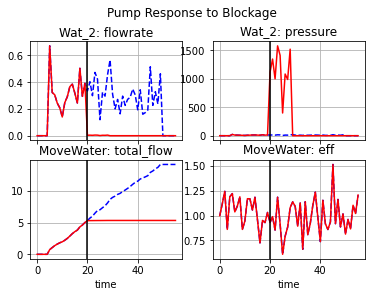

In [18]:
mdl = Pump()
endclass, mdlhist = propagate.one_fault(mdl, 'ExportWater','block', time=20, run_stochastic=True, modelparams={'seed':10})
fig = rd.plot.mdlhists(mdlhist, time_slice=[20], title="Pump Response to Blockage", fxnflowvals={'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure']}, legend_loc=False)

As shown the stochastic states still simulated over time after the fault. One thing to watch is thus that the stochastic update in the faulty scenario does or does not change the variables compared to the nominal state--since many of the visualizations (e.g., in `graph`) are based on finding *differences* between faulty and nominal models to visualize degradation, these methods may be less useful/reliable.

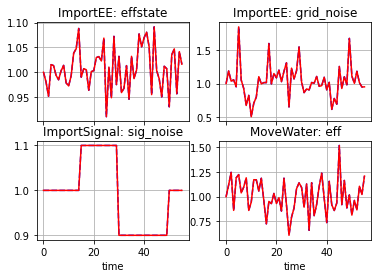

In [19]:
fig = rd.plot.mdlhists(mdlhist, fxnflowvals = {'ImportEE':["effstate","grid_noise"], 'ImportSignal':'sig_noise', 'MoveWater':'eff' }, legend_loc=False)

In the blockage scenario, there is no effect on the underlying stochastic states, since nothing was set up for this in the behavior. In the `no_sig` fault, on the other hand, we defined the signal noise to go to zero, as shown:

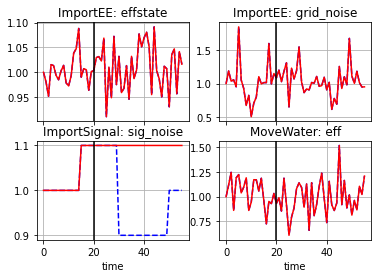

In [20]:
mdl = Pump()
endclass, mdlhist = propagate.one_fault(mdl, 'ImportSignal', 'no_sig', time=20, run_stochastic=True, modelparams={'seed':10})
fig = rd.plot.mdlhists(mdlhist, time_slice=20, fxnflowvals={'ImportEE':["effstate","grid_noise"], 'ImportSignal':'sig_noise', 'MoveWater':'eff' }, legend_loc=False)

### Multi-Scenario Simulation

Because stochastic models are non-deterministic, we are often interested not in the results of a single thread, but of the distribution of outcomes that might occur. To perform this kind of assessment, we can use a `NominalApproach` to instantiate the model with a number of different seeds.

In [21]:
help(NominalApproach.add_seed_replicates)

Help on function add_seed_replicates in module fmdtools.modeldef.approach:

add_seed_replicates(self, rangeid, seeds)
    Generates an approach with different seeds to use for the model's internal stochastic behaviors
    
    Parameters
    ----------
    rangeid : str
        Name for the set of replicates
    seeds : int/list
        Number of seeds (if an int) or a list of seeds to use.



A `seeds` option can also be used in several other NominalApproach methods to simultaneously change the input parameters and seeds of the model. Below, we create an approach to simulate the model 100 times.

In [22]:
app = NominalApproach()
app.add_seed_replicates('test_seeds', 100)

In [23]:
endclasses, mdlhists=propagate.nominal_approach(mdl,app, run_stochastic=True)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.35it/s]


To evaluate this behavior over time, we can then use `rd.plot.mdlhists`, which will plot the *distribution* of behaviors over time. 

In [24]:
help(rd.plot.mdlhists)

Help on function mdlhists in module fmdtools.resultdisp.plot:

mdlhists(mdlhists, fxnflowvals='all', cols=2, aggregation='individual', comp_groups={}, legend_loc=-1, xlabel='time', ylabels={}, max_ind='max', boundtype='fill', fillalpha=0.3, boundcolor='gray', boundlinestyle='--', ci=0.95, titles={}, title='', indiv_kwargs={'nominal': {'color': 'blue', 'ls': '--'}, 'faulty': {'color': 'red'}}, time_slice=[], time_slice_label=None, figsize='default', v_padding=None, h_padding=None, title_padding=0.0, phases={}, modephases={}, label_phases=True, legend_title=None, **kwargs)
    Plot the behavior over time of the given function/flow values 
    over a set of scenarios, with ability to aggregate behaviors as needed.
    
    Parameters
    ----------
    mdlhists : dict
        Aggregate model history with structure {'scen':mdlhist} (or single mdlhist)
    fxnflowvals : dict, optional
        dict of flow values to plot with structure {fxnflow:[vals], fxnflow:'val'/all, fxnflow:{'comp':[val

`rd.plot.mdlhists` has a number of different options for visualization. For example, below we plot model states as individual lines:

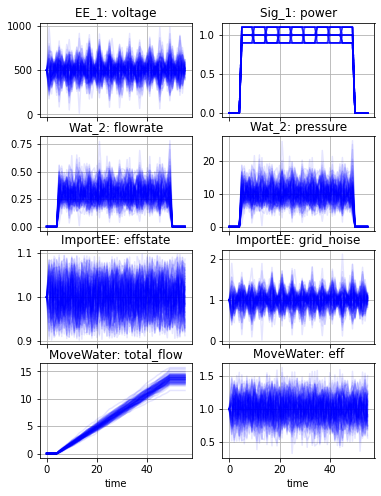

In [25]:
fig = rd.plot.mdlhists(mdlhists, {'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure'], 'ImportEE':['effstate', 'grid_noise'], 'EE_1':['voltage'], 'Sig_1':['power']}, color='blue', alpha=0.1, legend_loc=False)

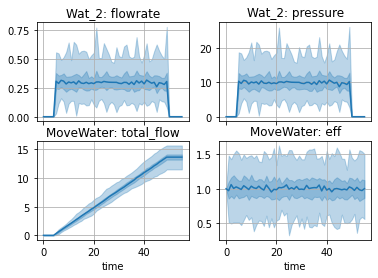

In [26]:
fig = rd.plot.mdlhists(mdlhists, {'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure']}, aggregation='percentile')

Or as percentiles:

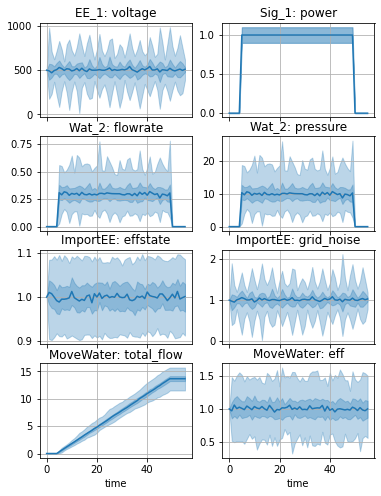

In [27]:
fig = rd.plot.mdlhists(mdlhists, {'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure'], 'ImportEE':['effstate', 'grid_noise'], 'EE_1':['voltage'], 'Sig_1':['power']}, aggregation='percentile') 

Or as a mean with confidence interval:

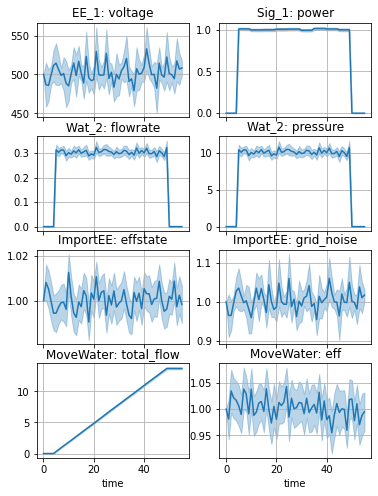

In [28]:
fig = rd.plot.mdlhists(mdlhists, {'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure'], 'ImportEE':['effstate', 'grid_noise'], 'EE_1':['voltage'], 'Sig_1':['power']}, aggregation='mean_ci') 

### Nested Fault Simulation

We can also compare stochastic output over a set of scenarios using `plot.mdlhistvals` with the `comp_groups` parameter, which places the scenarios in different groups.

In [29]:
def paramfunc(delay=1):
    return {'delay':delay}

This can be done by first creating an approach with two parameters we wish to compare. The pump still has one real parameter--the fault delay.

In [30]:
app_comp = NominalApproach()
app_comp.add_param_replicates(paramfunc, 'delay_1', 100, delay=1)
app_comp.add_param_replicates(paramfunc, 'delay_10', 100, delay=10)

Since this delay only shows up in blockage fault modes, to compare the behaviors, we will first simulate it in a nested approach with only the blockage fault added.

In [31]:
import multiprocessing as mp

In [32]:
pool=mp.Pool(4)

In [33]:
endclasses, mdlhists, apps=propagate.nested_approach(mdl,app_comp, run_stochastic=True, faults=[('ExportWater','block')])

NESTED SCENARIOS COMPLETE:   2%|█                                                      | 4/200 [00:00<00:14, 13.89it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:   4%|██▏                                                    | 8/200 [00:00<00:13, 14.42it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:   6%|███▏                                                  | 12/200 [00:00<00:13, 14.36it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:   7%|███▊                                                  | 14/200 [00:00<00:12, 14.35it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:   9%|████▊                                                 | 18/200 [00:01<00:12, 14.38it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  10%|█████▍                                                | 20/200 [00:01<00:12, 14.36it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  13%|███████                                               | 26/200 [00:01<00:12, 14.34it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  15%|████████                                              | 30/200 [00:02<00:11, 14.17it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  17%|█████████▏                                            | 34/200 [00:02<00:11, 14.13it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  18%|█████████▋                                            | 36/200 [00:02<00:11, 14.22it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  20%|██████████▊                                           | 40/200 [00:02<00:11, 14.32it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  22%|███████████▉                                          | 44/200 [00:03<00:10, 14.38it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  24%|████████████▉                                         | 48/200 [00:03<00:10, 14.21it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  25%|█████████████▌                                        | 50/200 [00:03<00:10, 13.89it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  28%|███████████████                                       | 56/200 [00:03<00:10, 14.27it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  29%|███████████████▋                                      | 58/200 [00:04<00:09, 14.44it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  31%|████████████████▋                                     | 62/200 [00:04<00:09, 14.34it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  34%|██████████████████▎                                   | 68/200 [00:04<00:09, 14.66it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  35%|██████████████████▉                                   | 70/200 [00:04<00:08, 14.46it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  37%|███████████████████▉                                  | 74/200 [00:05<00:08, 14.62it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  39%|█████████████████████                                 | 78/200 [00:05<00:08, 14.53it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  42%|██████████████████████▋                               | 84/200 [00:05<00:08, 14.32it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  43%|███████████████████████▏                              | 86/200 [00:06<00:07, 14.35it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  45%|████████████████████████▎                             | 90/200 [00:06<00:07, 14.07it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}

NESTED SCENARIOS COMPLETE:  47%|█████████████████████████▍                            | 94/200 [00:06<00:07, 14.16it/s]


Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  49%|██████████████████████████▍                           | 98/200 [00:06<00:07, 14.44it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE:  50%|██████████████████████████▌                          | 100/200 [00:06<00:06, 14.51it/s]

Faults found during the nominal run {'MoveWater': ['mech_break']}
Faults found during the nominal run {'MoveWater': ['mech_break']}


NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.18it/s]


Next, we get just the scenarios of interest:

In [34]:
comp_mdlhists = {scen:mdlhist['ExportWater block, t=27'] for scen,mdlhist in mdlhists.items()}

Finally, we create some comparison groups to group the results by:

In [35]:
comp_groups = {'delay_1': app_comp.ranges['delay_1']['scenarios'], 'delay_10':app_comp.ranges['delay_10']['scenarios']}

These are the resulting behaviors:

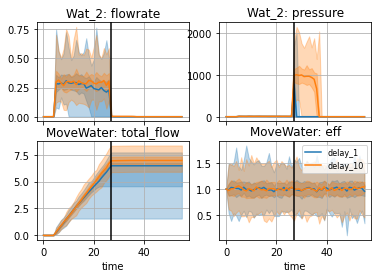

In [36]:
fig = rd.plot.mdlhists(comp_mdlhists, {'MoveWater':['eff','total_flow'], 'Wat_2':['flowrate','pressure']}, comp_groups=comp_groups, aggregation='percentile', time_slice=27) 

There a few interesting aspects of this simulation:
    - First, some of the `delay_1` design simulations have a zero flowrate before the fault is injected. This is because the reduced delay means that nominal behavior can easily cause the fault--all that nees to happen is for the pressure to go over 15 for two time-steps, which is entirely forseeable with all the variability in the simulation. This can also be seen in the "total_flow" graph.
    - Second, the `delay_10` gives the nominal behavior until the fault time, when pressure increases dramatically. This is also observed in the `delay_1` design, but with a much smaller delay (1 instead of 1).

Finally, running multiple simulations relies on the NominalApproach, it can be combined fairly easily with existing methods used in conjunction with NominalApproach. (e.g., `tabulate.nested_stats`).

In [37]:
rd.tabulate.nested_stats(app_comp, endclasses, average_metrics=['cost'], inputparams=['delay'])

,delay_1_1,delay_1_2,delay_1_3,delay_1_4,delay_1_5,delay_1_6,delay_1_7,delay_1_8,delay_1_9,delay_1_10,...,delay_10_191,delay_10_192,delay_10_193,delay_10_194,delay_10_195,delay_10_196,delay_10_197,delay_10_198,delay_10_199,delay_10_200
delay,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.00000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
ave_cost,9976.549974,9562.267369,10115.589115,10224.053914,9884.272092,9264.114708,9858.188991,9922.271279,9056.137356,9977.280289,...,10231.31273,10163.464585,10500.760544,10167.04239,9937.824464,10119.693345,10189.894444,10003.602361,10330.194536,10008.821694


In [38]:
rd.tabulate.resilience_factor_comparison(app_comp, endclasses, ['delay'], 'cost',  difference=False, percent=False)

"(delay,)",nominal,ExportWater
delay_1,3750.0,12368.435489
delay_10,0.0,13424.666897
